# **Preprocessing Step**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Load Excel file
df = pd.read_excel("/content/AirQualityUCI.xlsx", engine='openpyxl')

In [ ]:
#Remove empty columns
df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], inplace=True, errors='ignore')

In [ ]:
# Create datetime column as a timestamp index
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str),
                                 errors='coerce', dayfirst=True)
df.set_index('Datetime', inplace=True)


In [ ]:
#Keep only the required inputs and outputs
df.drop(columns=['Date', 'Time'], inplace=True)


In [ ]:
# Define input features and the target column
input_features = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)',
                  'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
target_column = 'C6H6(GT)'


In [ ]:
# Keep only the required inputs and outputs
df = df[input_features + [target_column]].dropna()
#Normalize values between 0 and 1
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df),
                         columns=input_features + [target_column],
                         index=df.index)


In [ ]:
#Print a sample of the processed data
print(df_scaled.head())


                     PT08.S1(CO)  PT08.S2(NMHC)  PT08.S3(NOx)  PT08.S4(NO2)  \
Datetime                                                                      
2004-10-03 18:00:00     0.696506       0.515949      0.435782      0.635966   
2004-10-03 19:00:00     0.666257       0.478355      0.476541      0.591176   
2004-10-03 20:00:00     0.715258       0.471935      0.464834      0.589748   
2004-10-03 21:00:00     0.703427       0.475663      0.448183      0.599580   
2004-10-03 22:00:00     0.657328       0.428956      0.487382      0.568067   

                     PT08.S5(O3)         T        RH        AH  C6H6(GT)  
Datetime                                                                  
2004-10-03 18:00:00     0.538977  0.873262  0.861979  0.992715  0.803369  
2004-10-03 19:00:00     0.430539  0.872036  0.857910  0.992555  0.793949  
2004-10-03 20:00:00     0.467909  0.866312  0.879643  0.992678  0.792434  
2004-10-03 21:00:00     0.515380  0.862633  0.900511  0.992858  0.79331

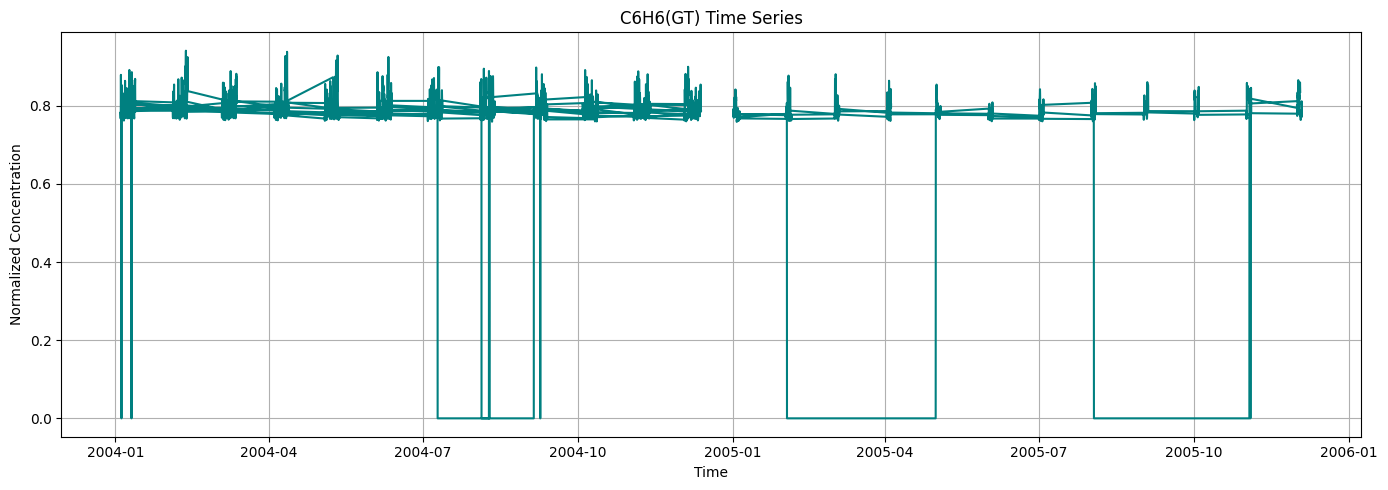

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#===== 1. Time series plot of C6H6 concentration (Target) =====
plt.figure(figsize=(14, 5))
plt.plot(df_scaled.index, df_scaled['C6H6(GT)'], color='teal')
plt.title('C6H6(GT) Time Series')
plt.xlabel('Time')
plt.ylabel('Normalized Concentration')
plt.grid(True)
plt.tight_layout()
plt.show()


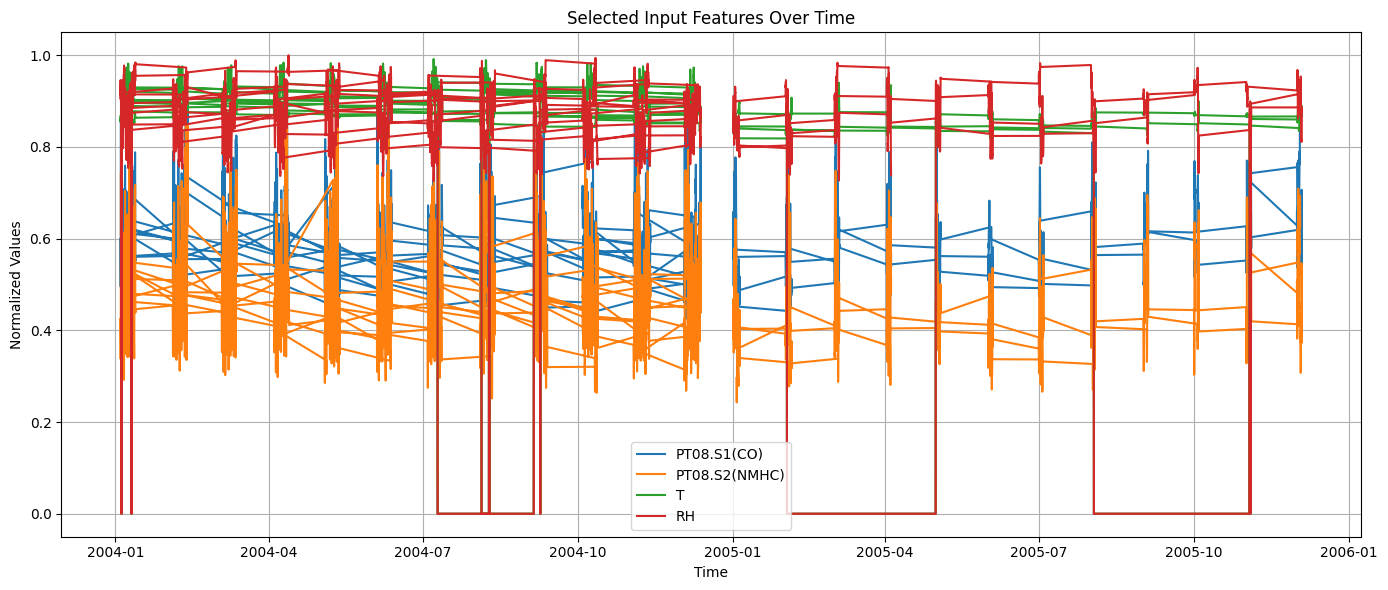

In [ ]:
#===== 2. Time series plot of some Inputs =====
plt.figure(figsize=(14, 6))
for col in ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'T', 'RH']:
    plt.plot(df_scaled.index, df_scaled[col], label=col)
plt.title('Selected Input Features Over Time')
plt.xlabel('Time')
plt.ylabel('Normalized Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


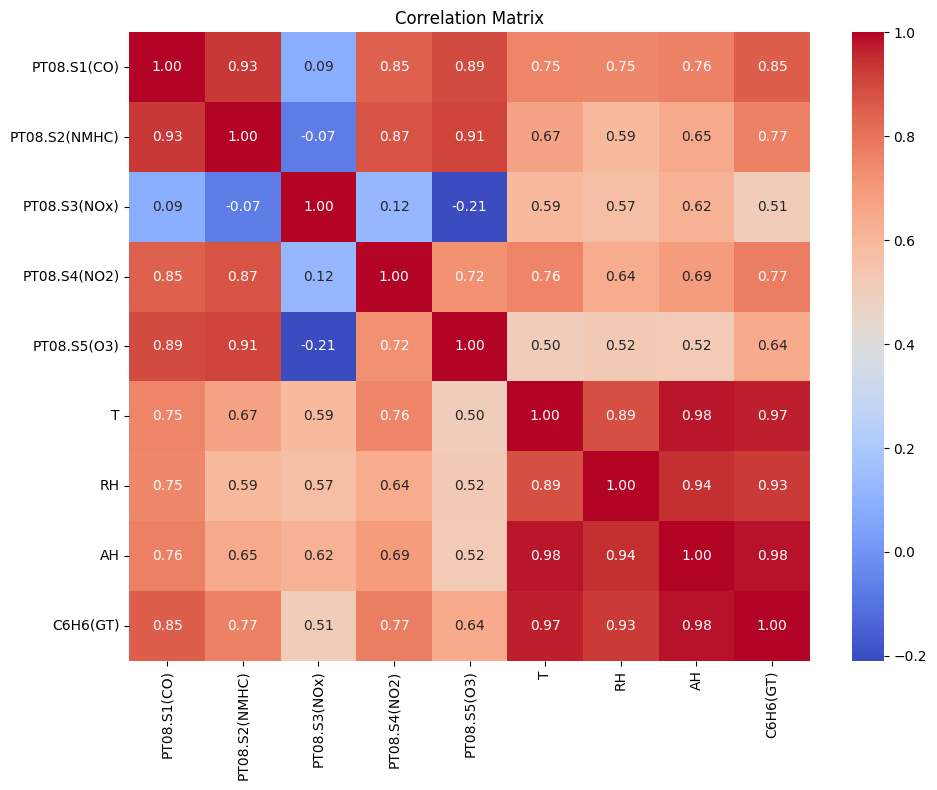

In [ ]:
#===== 3. Correlation matrix (Heatmap) =====
plt.figure(figsize=(10, 8))
corr_matrix = df_scaled.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


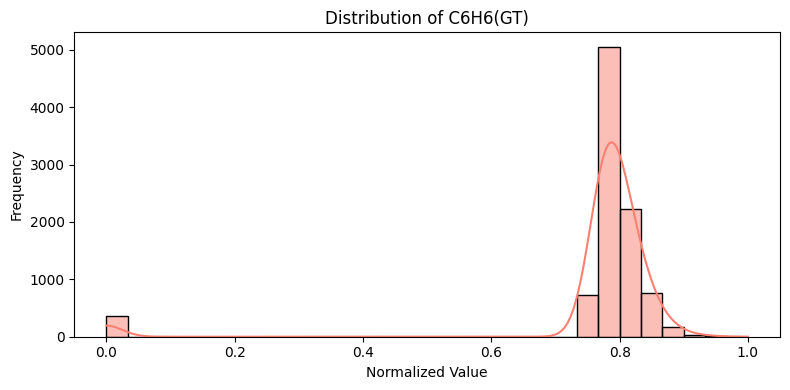

In [ ]:
#===== 4. Distribution plot for C6H6 (GT) =====
plt.figure(figsize=(8, 4))
sns.histplot(df_scaled['C6H6(GT)'], bins=30, kde=True, color='salmon')
plt.title('Distribution of C6H6(GT)')
plt.xlabel('Normalized Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [ ]:
#Prepare the data sequence
#Number of time steps used

TIME_STEPS = 24

#Convert the data to sequences
def create_sequences(data, target_col_index, time_steps=TIME_STEPS):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, :-1])  # جميع الأعمدة ما عدا الـ target
        y.append(data[i+time_steps, target_col_index])  # الهدف في المستقبل
    return np.array(X), np.array(y)

#Convert DataFrame to NumPy array
data_array = df_scaled.values
target_index = df_scaled.columns.get_loc("C6H6(GT)")

X, y = create_sequences(data_array, target_index, TIME_STEPS)

#Final shape of the data
print("X shape:", X.shape)  # (samples, time_steps, features)
print("y shape:", y.shape)  # (samples,)

X shape: (9333, 24, 8)
y shape: (9333,)


In [ ]:
# تقسيم البيانات إلى تدريب، تحقق، واختبار بنسبة 70%، 15%، 15%
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

print("Training samples :", X_train.shape[0])
print("Validation samples:", X_val.shape[0])
print("Testing samples   :", X_test.shape[0])


Training samples : 6533
Validation samples: 1399
Testing samples   : 1401


# **Bi-LSTM**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense

# 1.Building a Bi-LSTM Model
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))  # Output a single value

model.compile(optimizer='adam', loss='mse')

#View form summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 128)            │        37,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,505 (146.50 KB)

 Trainable params: 37,505 (146.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 2.Model training
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50, batch_size=32,
                    verbose=1)

Epoch 1/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0636 - val_loss: 0.0111
Epoch 2/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0042 - val_loss: 0.0077
Epoch 3/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0026 - val_loss: 0.0072
Epoch 4/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.0030 - val_loss: 0.0062
Epoch 5/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0028 - val_loss: 0.0057
Epoch 6/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0029 - val_loss: 0.0055
Epoch 7/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0031 - val_loss: 0.0052
Epoch 8/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0027 - val_loss: 0.0047
Epoch 9/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0025 - val_loss: 0.0049
Epoch 10/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0026 - val_loss: 0.0046
Epoch 11/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0016 - val_loss: 0.0046
Epoch 12/50
205/205 ━━━━━━━━━━━━━━━━━━━

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prediction on validation data
y_val_pred = model.predict(X_val)

# Prediction on test data
y_test_pred = model.predict(X_test)

# Evaluation on validation
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

# Evaluation on test
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print results
print("\n Validation Evaluation:")
print("MSE :", mse_val)
print("RMSE:", rmse_val)
print("MAE :", mae_val)
print("R² Score:", r2_val)
print("---------------------------------")

print("\n Testing Evaluation:")
print("MSE :", mse_test)
print("RMSE:", rmse_test)
print("MAE :", mae_test)
print("R² Score:", r2_test)
print("---------------------------------")


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

 Validation Evaluation:
MSE : 0.004363477128257788
RMSE: 0.06605662062396007
MAE : 0.022390461561234705
R² Score: 0.9242712471519935
---------------------------------

 Testing Evaluation:
MSE : 0.0019757566573625385
RMSE: 0.044449484331795554
MAE : 0.0172338743886375
R² Score: 0.9396161671123799
---------------------------------


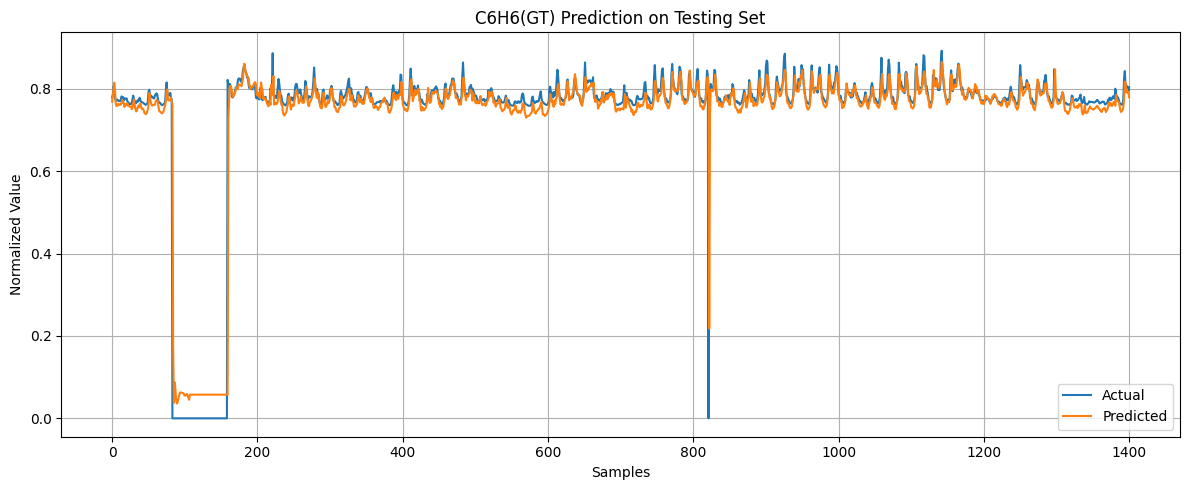

In [ ]:
# Plotting actual vs. predicted values ​​for testing data
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title('C6H6(GT) Prediction on Testing Set')
plt.xlabel('Samples')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

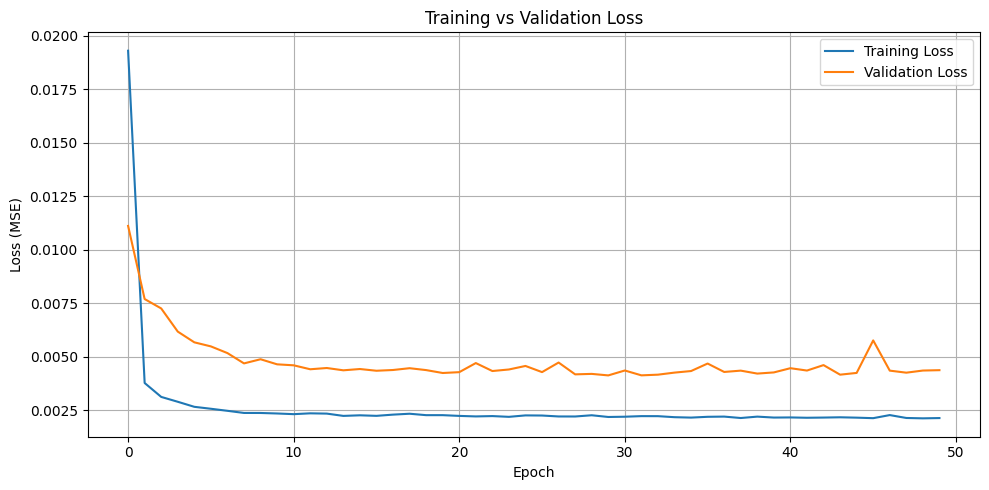

In [ ]:
# Draw a loss curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()

     Model       MSE      RMSE       MAE        R²
0      ESN  0.003098  0.055655  0.024494  0.905333
1     LSTM  0.001967  0.044352  0.015350  0.939881
2  Bi-LSTM  0.001976  0.044449  0.017234  0.939616




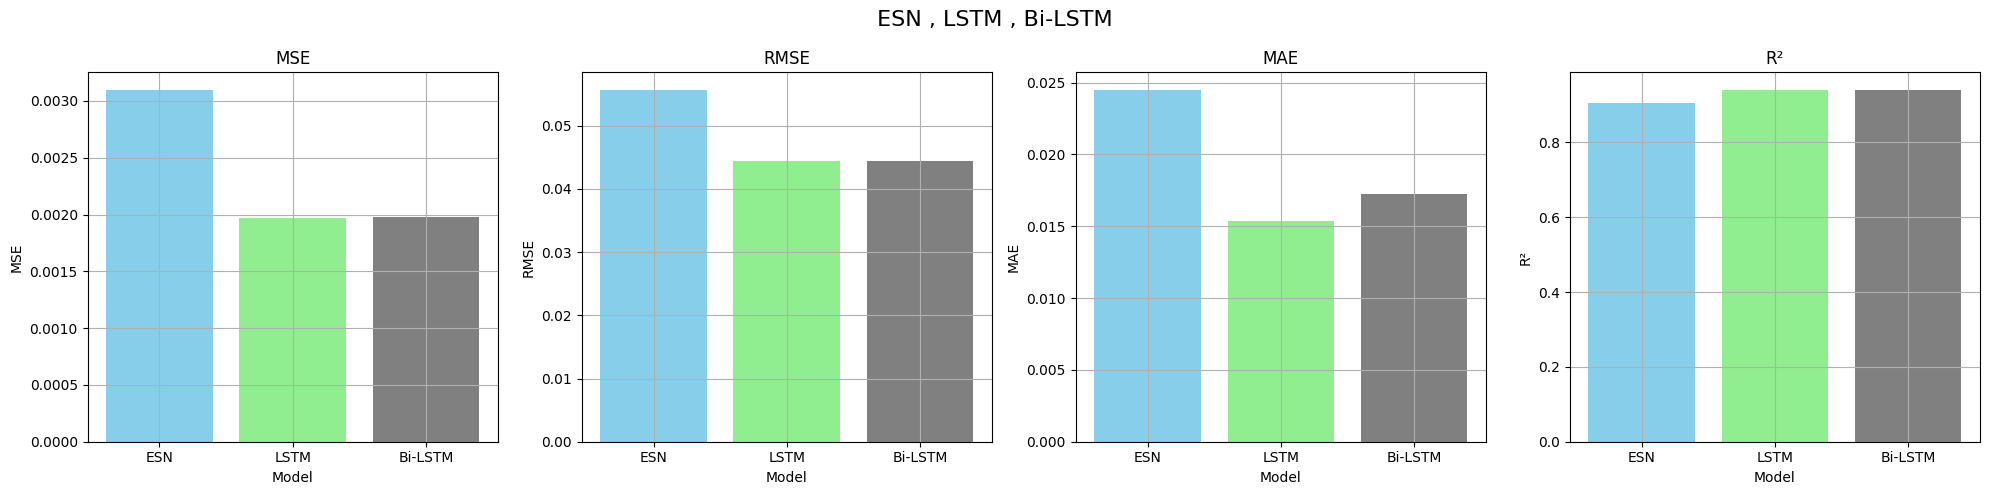

In [ ]:

# Results
results = {
    'Model': ['ESN', 'LSTM', 'Bi-LSTM'],
    'MSE': [0.0030975165869527076, 0.0019670990772106206, 0.0019757566573625385],
    'RMSE': [0.05565533745250951, 0.044351990679231304, 0.044449484331795554],
    'MAE': [ 0.024493963546227264, 0.015349630160303425, 0.0172338743886375],
    'R²': [0.9053325098229125, 0.9398807633981404, 0.9396161671123799]
}
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame
df_results = pd.DataFrame(results)

# Print results
print(df_results)
print("\n")

# comparison
metrics = ['MSE', 'RMSE', 'MAE', 'R²']
fig, axs = plt.subplots(1, len(metrics), figsize=(20, 5))

for i, metric in enumerate(metrics):
    axs[i].bar(df_results['Model'], df_results[metric], color=['skyblue', 'lightgreen', 'gray'])
    axs[i].set_title(metric)
    axs[i].set_xlabel('Model')
    axs[i].set_ylabel(metric)
    axs[i].grid(True)

plt.suptitle(" ESN , LSTM , Bi-LSTM ", fontsize=16)
plt.tight_layout()
plt.show()
